# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni DSLab computers according to the README.MD instructions without ANY exceptions on the DSLab machines: 3pt
2. Perfect 1:1 reproducibility on DSLab machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test". 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
from collections import Counter
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(18)
random.seed(18)
np.random.seed(18)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(18)

transform = transforms.ToTensor()


# Define transformations (convert to tensor + normalize if you want)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),  # Convert PIL image to Tensor
    # NORMALISATION -do or not do- 3 channels with each entry in range [0-1]
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) 
])

# Load datasets
train_dataset = datasets.ImageFolder(root="train", transform=transform)
test_dataset = datasets.ImageFolder(root="test", transform=transform)

# reads an example image
image, label = train_dataset[84]
print(image, label)

# Use DataLoaders -> adjust batch size (batch size-number of pictures processed at once)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


tensor([[[0.8039, 0.8039, 0.8039,  ..., 0.6941, 0.6784, 0.6706],
         [0.8039, 0.8039, 0.7961,  ..., 0.6941, 0.6784, 0.6706],
         [0.8039, 0.7961, 0.7961,  ..., 0.6863, 0.6784, 0.6784],
         ...,
         [0.4039, 0.4039, 0.4118,  ..., 0.2157, 0.2157, 0.2157],
         [0.4196, 0.4196, 0.4118,  ..., 0.2314, 0.2314, 0.2314],
         [0.4275, 0.4196, 0.4118,  ..., 0.2471, 0.2471, 0.2392]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.5686, 0.5529, 0.5451],
         [0.8745, 0.8745, 0.8667,  ..., 0.5686, 0.5529, 0.5451],
         [0.8745, 0.8667, 0.8667,  ..., 0.5686, 0.5608, 0.5608],
         ...,
         [0.5373, 0.5373, 0.5451,  ..., 0.1843, 0.1843, 0.1843],
         [0.5373, 0.5373, 0.5294,  ..., 0.2000, 0.2000, 0.2000],
         [0.5451, 0.5373, 0.5294,  ..., 0.2157, 0.2157, 0.2078]],

        [[0.8667, 0.8667, 0.8667,  ..., 0.6471, 0.6314, 0.6235],
         [0.8667, 0.8667, 0.8588,  ..., 0.6471, 0.6314, 0.6235],
         [0.8667, 0.8588, 0.8588,  ..., 0.6235, 0.6157, 0.

# CNN Implementation

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FoodCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #all the convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

        #pooling reduces the dimensions by half
        self.pool = nn.MaxPool2d(2,2)

        self.flatten = nn.Flatten()

        #fully connected layers of the model, working with the flatten version of the input
        self.fc1 = nn.Linear(64*32*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128 ,91)

        #optionally
        #self.fc1 = Linear(64*32*32, 256)
        #self.fc2 = Linear(256, 91)

        self._train_and_save_model()

    def forward(self, X):
        #convulution and pooling operations
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = F.relu(self.conv3(X))
        X = self.pool(X)

        #flattens the input to fully connected layers
        X = self.flatten(X)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        #last layer categorises the input
        X = self.fc3(X)
        return X
    
    def _train_and_save_model(self):
        pass

# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [ ]:
def _train_and_save_model(self):
    self.to(device)
    torch.manual_seed(18)
    #epoch = 5
    epochs = 1

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    best_train_accuracy = 0.0

    for e in range(epochs):
        self.train()
        training_correct = 0
        total_train = 0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            #resets the optimizer to 0
            optimizer.zero_grad()
            #outputs a tensor with values assigned to each class
            y_pred = self(X_train)
            loss = criterion(y_pred, y_train)

            #backpropagates; accumulates the gradient for each parameter
            loss.backward()
            #parameters update
            optimizer.step()

            label_pred = torch.argmax(y_pred, dim=1)
            #total count of correct classifications
            training_correct += (label_pred == y_train).sum().item()
            #number of label in an epoch
            total_train += y_train.size(0)

        train_accuracy = (training_correct / total_train) / 100
        print(f"Training accuracy of epoch {e+1}: {train_accuracy}.")

        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy
            torch.save(self.state_dict(), "best_model.pth")

FoodCNN._train_and_save_model = _train_and_save_model

# Calculating model performance
Load the best version of your model ( which should be produced and saved by previous cells ), calculate and report the test accuracy.

In [ ]:
# Load the best model weights
model = FoodCNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))

def calculate_test_accuracy(model):
    model.eval()
    test_correct = 0
    total_test = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            predictions = torch.argmax(outputs, dim=1)
            test_correct += (predictions == y_test).sum().item()
            total_test += y_test.size(0)

    test_accuracy = (test_correct / total_test) * 100
    return test_accuracy

final_test_acc = calculate_test_accuracy(model)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")


# Summary of hyperparameters
Report the hyperparameters ( learning rate etc ) that you used in your final model for reproducibility.

# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

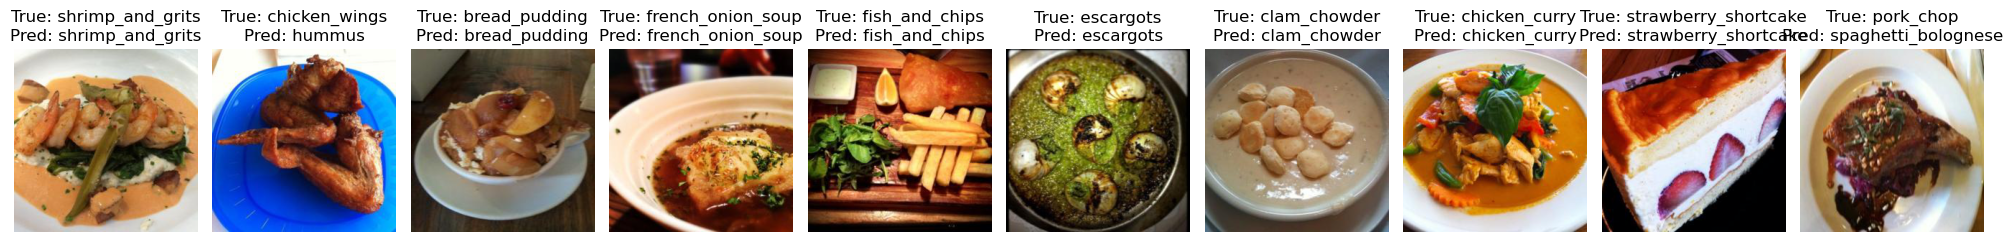

Predicted Class Frequencies: {'bread_pudding': 1, 'chicken_curry': 1, 'clam_chowder': 1, 'escargots': 1, 'fish_and_chips': 1, 'french_onion_soup': 1, 'hummus': 1, 'shrimp_and_grits': 1, 'spaghetti_bolognese': 1, 'strawberry_shortcake': 1}
True Class Frequencies: {'bread_pudding': 1, 'chicken_curry': 1, 'chicken_wings': 1, 'clam_chowder': 1, 'escargots': 1, 'fish_and_chips': 1, 'french_onion_soup': 1, 'pork_chop': 1, 'shrimp_and_grits': 1, 'strawberry_shortcake': 1}


In [ ]:
def user_behaviour_simulation(model):
    model.eval()

    random_indices = random.sample(range(len(test_dataset)), 10)

    true_labels = []
    predicted_labels = []

    for idx in random_indices:
        image, label = test_dataset[idx]
        true_labels.append(label)

        #adjusts an image to be viewed as a batch
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            pred_label = torch.argmax(output, dim=1).item()
            predicted_labels.append(pred_label)

    #maps the indices of the classes to their real names from the dataset
    class_names = test_dataset.classes
    true_class_names = [class_names[i] for i in true_labels]
    pred_class_names = [class_names[i] for i in predicted_labels]

    #stores the classes names with their counts in a separate dictionaries
    true_counts = dict(Counter(true_class_names))
    pred_counts = dict(Counter(pred_class_names))

    #formats output as expected
    print("Predicted Class Frequencies:", pred_counts)
    print("True Class Frequencies:", true_counts)

user_behaviour_simulation(model)

# Bonus point
Use an LLM (API) to generate a description of the food preference of a user based on 10 images that a potential user could provide. 
Please include an example of the output of your code, especially if you used an API other than the OpenAI API.

This should work well even with differing test images by setting different random seeds for the image selector.